**Code we used we used to generate the positional effect visualizations**

In [1]:
import os
import sys
import pathlib
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
import seaborn as sns
import matplotlib.pyplot as plt
import random

HOME_DIR = str(pathlib.Path(os.path.abspath('')).parent) + "/"  # project path
sys.path.append(HOME_DIR)

from OT_deep_score_src.data_processing_utilities import build_sequence_features
from OT_deep_score_src.general_utilities import Padding_type


FILES_DIR = HOME_DIR + "files/"
DATASETS_PATH = FILES_DIR + "datasets/"
flat_encoding = False

2024-03-26 19:28:06.188080: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-26 19:28:08.807438: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


*Spesific base type analysis*

In [2]:
def ensemble_predict(modles, x):
    return np.mean([model.predict(x, verbose=0) for model in modles], axis=0)


def signle_mismatch_to_bases(models, ref_seqs, model_name, label):
    seq_len = 23
    bases = ["A", "C", "G", "T"]
    y_pos_values = [{base: np.nan for base in bases} for _ in range(seq_len)]
    e = [{base: np.nan for base in bases} for _ in range(seq_len)]
    for i in range(seq_len):
        pos_off_targets = {base: [] for base in bases}
        pos_sg_rnas = {base: [] for base in bases}
        if i == 20:
            continue
        for ref_seq in ref_seqs:
            for base in bases:
                if base == ref_seq[i]:
                    continue
                off_target_seq = ref_seq[:i] + base + ref_seq[i+1:]
                if i != 20:
                    off_target_seq = off_target_seq.replace("N", "G")
                else:
                    continue
                pos_off_targets[base].append(off_target_seq)
                pos_sg_rnas[base].append(ref_seq)
        for base in bases:
            if i >= 20 and base in ["G"]:
                continue
            off_target_df = pd.DataFrame(data={"Align.sgRNA": pos_sg_rnas[base], "Align.off-target": pos_off_targets[base]})
            off_target_featuers = build_sequence_features(
                    off_target_df, bulges=True, aligned=True,
                    padding_type=Padding_type.GAP,
                    flat_encoding=flat_encoding, verbose=0)
            if model_name.find("Emb") != -1:
                x = np.argmax(off_target_featuers, axis=2)
            else:
                x = off_target_featuers
            predictions = ensemble_predict(models, x)
            y_pos_values[i][base] = np.mean(predictions)
            e[i][base] = np.std(predictions)

    _, ax = plt.subplots(figsize=(8, 3))
    x = range(1, seq_len + 1)
    for base in bases:
        base_y_pos_values = [y_pos_values[i][base] for i in range(seq_len)]
        base_e = [e[i][base] for i in range(seq_len)]
        # ax.errorbar(x, base_y_pos_values, yerr=base_e, fmt='o', capsize=5, zorder=0)
        # ax.scatter(x, base_y_pos_values, c=base_y_pos_values, zorder=5, s=60)
        ax.scatter(x, base_y_pos_values, label="To " + base, zorder=5, s=60)

    ax.set_xticks(x)
    ax.set_title("{} - Single mismatch effect on off-target cleavage efficiency".format(model_name))
    ax.set_ylabel(label)
    ax.set_xlabel("Mismatch position")
    plt.legend()
    # Display the plot
    plt.tight_layout()
    plt.savefig("plots/bases_to_single_mismatch_bulge_effect_{}.png".format(model_name.replace("-", "_")), dpi=1000, transparent=True, bbox_inches='tight')


def signle_mismatch_from_bases(models, ref_seqs, model_name, label):
    seq_len = 23
    bases = ["A", "C", "G", "T"]
    y_pos_values = [{base: np.nan for base in bases} for _ in range(seq_len)]
    e = [{base: np.nan for base in bases} for _ in range(seq_len)]
    for i in range(seq_len):
        pos_off_targets = {base: [] for base in bases}
        pos_sg_rnas = {base: [] for base in bases}
        if i == 20:
            continue
        for ref_seq in ref_seqs:
            for base in bases:
                if base == ref_seq[i]:
                    continue
                off_target_seq = ref_seq[:i] + base + ref_seq[i+1:]
                if i != 20:
                    off_target_seq = off_target_seq.replace("N", "G")
                else:
                    continue
                pos_off_targets[ref_seq[i]].append(off_target_seq)
                pos_sg_rnas[ref_seq[i]].append(ref_seq)
        for base in bases:
            if i >= 20 and base in ["A", "C", "T"]:
                continue
            off_target_df = pd.DataFrame(data={"Align.sgRNA": pos_sg_rnas[base], "Align.off-target": pos_off_targets[base]})
            off_target_featuers = build_sequence_features(
                    off_target_df, bulges=True, aligned=True,
                    padding_type=Padding_type.GAP,
                    flat_encoding=flat_encoding, verbose=0)
            if model_name.find("Emb") != -1:
                x = np.argmax(off_target_featuers, axis=2)
            else:
                x = off_target_featuers
            predictions = ensemble_predict(models, x)
            y_pos_values[i][base] = np.mean(predictions)
            e[i][base] = np.std(predictions)

    _, ax = plt.subplots(figsize=(8, 3))
    x = range(1, seq_len + 1)
    for base in bases:
        base_y_pos_values = [y_pos_values[i][base] for i in range(seq_len)]
        base_e = [e[i][base] for i in range(seq_len)]
        # ax.errorbar(x, base_y_pos_values, yerr=base_e, fmt='o', capsize=5, zorder=0)
        # ax.scatter(x, base_y_pos_values, c=base_y_pos_values, zorder=5, s=60)
        ax.scatter(x, base_y_pos_values, label="From " + base, zorder=5, s=60)

    ax.set_xticks(x)
    ax.set_title("{} - Single mismatch effect on off-target cleavage efficiency".format(model_name))
    ax.set_ylabel(label)
    ax.set_xlabel("Mismatch position")
    plt.legend()
    # Display the plot
    plt.tight_layout()
    plt.savefig("plots/bases_from_single_mismatch_bulge_effect_{}.png".format(model_name.replace("-", "_")), dpi=1000, transparent=True, bbox_inches='tight')

def single_rna_bulge_bases(models, ref_seqs, model_name, label):
    seq_len = 23
    bases = ["A", "C", "G", "T"]
    y_pos_values = [{base: np.nan for base in bases} for _ in range(seq_len)]
    e = [{base: np.nan for base in bases} for _ in range(seq_len)]
    for i in range(seq_len):
        pos_off_targets = {base: [] for base in bases}
        pos_sg_rnas = {base: [] for base in bases}
        if i == 20:
            continue
        for ref_seq in ref_seqs:
            off_target_seq = ref_seq[:i] + "-" + ref_seq[i + 1:]
            off_target_seq = off_target_seq.replace("N", "G")
            pos_off_targets[ref_seq[i]].append(off_target_seq)
            pos_sg_rnas[ref_seq[i]].append(ref_seq)
        for base in bases:
            if i >= 20 and base in ["A", "C", "T"]:
                continue
            off_target_df = pd.DataFrame(data={"Align.sgRNA": pos_sg_rnas[base], "Align.off-target": pos_off_targets[base]})
            off_target_featuers = build_sequence_features(
                    off_target_df, bulges=True, aligned=True,
                    padding_type=Padding_type.GAP,
                    flat_encoding=flat_encoding, verbose=0)
            if model_name.find("Emb") != -1:
                x = np.argmax(off_target_featuers, axis=2)
            else:
                x = off_target_featuers

            predictions = ensemble_predict(models, x)
            y_pos_values[i][base] = np.mean(predictions)
            e[i][base] = np.std(predictions)

    _, ax = plt.subplots(figsize=(8, 3))
    x = range(1, seq_len + 1)
    for base in bases:
        base_y_pos_values = [y_pos_values[i][base] for i in range(seq_len)]
        base_e = [e[i][base] for i in range(seq_len)]
        # ax.errorbar(x, base_y_pos_values, yerr=base_e, fmt='o', capsize=5, zorder=0)
        # ax.scatter(x, base_y_pos_values, c=base_y_pos_values, zorder=5, s=60)
        ax.scatter(x, base_y_pos_values, label=base, zorder=5, s=60)

    ax.set_xticks(x)
    ax.set_title("{} - Single RNA bulge effect on off-target cleavage efficiency".format(model_name))
    ax.set_ylabel(label)
    ax.set_xlabel("RNA bulge position")
    plt.legend()
    # Display the plot
    plt.tight_layout()
    plt.savefig("plots/bases_single_rna_bulge_effect_{}.png".format(model_name.replace("-", "_")), dpi=1000, transparent=True, bbox_inches='tight')


def single_dna_bulge_bases(models, ref_seqs, model_name, label):
    seq_len = 23
    bases = ["A", "C", "G", "T"]
    y_pos_values = [{base: np.nan for base in bases} for _ in range(seq_len)]
    e = [{base: np.nan for base in bases} for _ in range(seq_len)]
    for i in range(1, seq_len):
        pos_off_targets = {base: [] for base in bases}
        pos_sg_rnas = {base: [] for base in bases}
        for ref_seq in ref_seqs:
            for base in bases:
                off_target_seq = ref_seq.replace("N", "G")
                off_target_seq = off_target_seq[:i] + base + off_target_seq[i:]
                ref_seq_with_gap = ref_seq[:i] + "-" + ref_seq[i:]
                pos_off_targets[base].append(off_target_seq)
                pos_sg_rnas[base].append(ref_seq_with_gap)

        for base in bases:
            off_target_df = pd.DataFrame(data={"Align.sgRNA": pos_sg_rnas[base], "Align.off-target": pos_off_targets[base]})
        
            off_target_featuers = build_sequence_features(
                    off_target_df, bulges=True, aligned=True,
                    padding_type=Padding_type.GAP,
                    flat_encoding=flat_encoding, verbose=0)
            if model_name.find("Emb") != -1:
                x = np.argmax(off_target_featuers, axis=2)
            else:
                x = off_target_featuers

            predictions = ensemble_predict(models, x)
            y_pos_values[i][base] = np.mean(predictions)
            e[i][base] = np.std(predictions)

    
    _, ax = plt.subplots(figsize=(8, 3))
    x = range(2, seq_len + 1)
    for base in bases:
        base_y_pos_values = [y_pos_values[i][base] for i in range(1, seq_len)]
        base_e = [e[i][base] for i in range(1, seq_len)]
        # ax.errorbar(x, base_y_pos_values, yerr=base_e, fmt='o', capsize=5, zorder=0)
        # ax.scatter(x, base_y_pos_values, c=base_y_pos_values, zorder=5, s=60)
        ax.scatter(x, base_y_pos_values, label=base, zorder=5, s=60)

    ax.set_xticks(x)
    ax.set_title("{} - Single DNA bulge effect on off-target cleavage efficiency".format(model_name))
    ax.set_ylabel(label)
    ax.set_xlabel("DNA bulge position")

    plt.legend()
    # Display the plot
    plt.tight_layout()
    plt.savefig("plots/bases_single_dna_bulge_effect_{}.png".format(model_name.replace("-", "_")), dpi=1000, transparent=True, bbox_inches='tight')

In [3]:
def positions_plots_bases(models, model_name):
    if model_name.find("Reg") != -1:
        label = "Average off-target cleavage\nefficiency prediction"
    else:
        label = "Average off-target\ncleavage probability"
    ref_seqs = []
    for i in range(300, 500):
        random.seed(i)
        bases = ["A", "C", "G", "T"]
        # ref_seq =  dataset_df[SG_RNA].unique()[21]
        ref_seq = ''.join([random.choice(bases) for _ in range(20)]) + "NGG"
        ref_seqs.append(ref_seq)
    
    signle_mismatch_from_bases(models, ref_seqs, model_name, label)
    signle_mismatch_to_bases(models, ref_seqs, model_name, label)
    single_rna_bulge_bases(models, ref_seqs, model_name, label)
    single_dna_bulge_bases(models, ref_seqs, model_name, label)

2024-03-26 19:33:13.502419: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-26 19:33:13.505544: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-26 19:33:13.507375: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

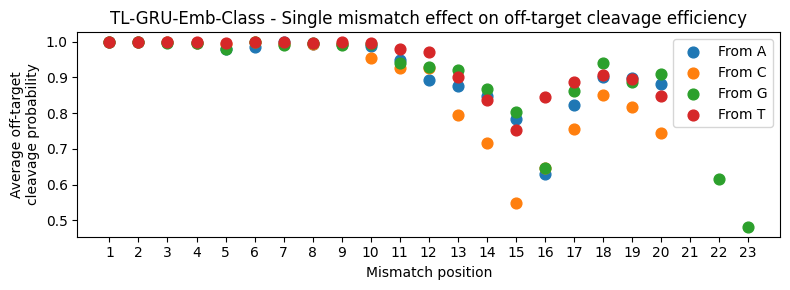

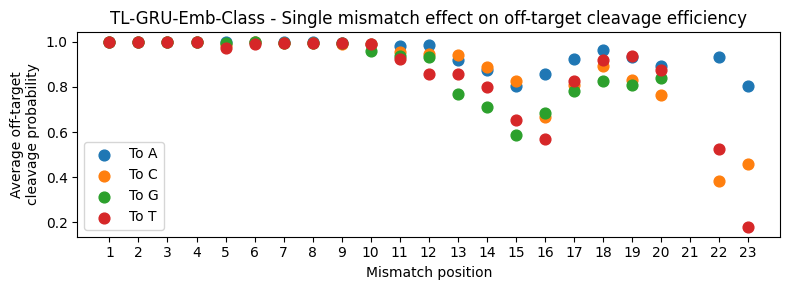

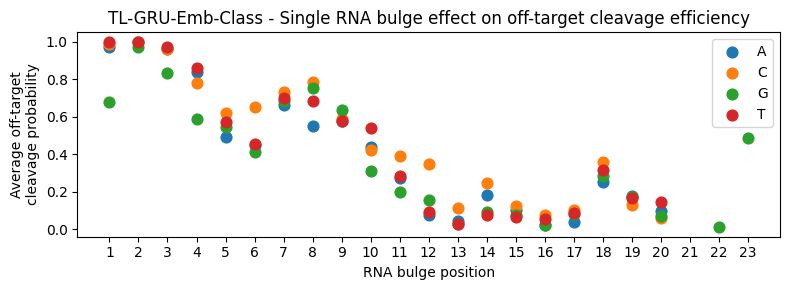

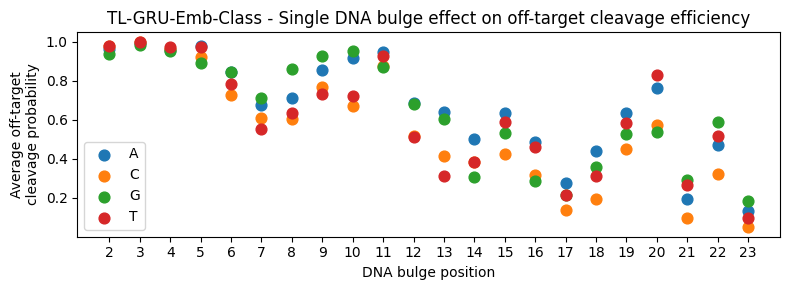

In [7]:
models = [load_model(FILES_DIR + 'bulges/1_folds/5_revision_ensemble_{}_exclude_RHAMPseq_continue_from_change_seq/read_ts_0/cleavage_models/aligned/FullGUIDEseq/classification/c_2/ln_x_plus_one_trans/model_fold_0.h5'.format(i)) for i in range(5)]
positions_plots_bases(models, model_name="TL-GRU-Emb-Class")

*Average over bases and epistasis-like combinatorial effect of two mismatches analysis*

In [18]:
def double_mismatches_with_diff(models, ref_seqs, model_name, label):
    bases = ["A", "C", "G", "T"]
    pos_values_matrix = np.zeros((23, 23))
    pos_values_matrix[:] = np.nan
    for i in range(23):
        for j in range(i, 23):
            pos_off_targets = []
            pos_sg_rnas = []
            if i == 20 or j == 20:
                continue
            for ref_seq in ref_seqs:
                for base_to_pos_i in bases:
                    if base_to_pos_i == ref_seq[i]:
                        continue
                    off_target_seq = ref_seq[:i] + base_to_pos_i + ref_seq[i+1:]
                    for base_to_pos_j in bases:
                        if base_to_pos_j == ref_seq[j]:
                            continue
                        off_target_seq = off_target_seq[:j] + base_to_pos_j + off_target_seq[j+1:]
                        off_target_seq = off_target_seq.replace("N", "G")
                        pos_off_targets.append(off_target_seq)
                        pos_sg_rnas.append(ref_seq)
            off_target_df = pd.DataFrame(data={"Align.sgRNA": pos_sg_rnas, "Align.off-target": pos_off_targets})
            off_target_featuers = build_sequence_features(
                    off_target_df, bulges=True, aligned=True,
                    padding_type=Padding_type.GAP,
                    flat_encoding=flat_encoding, verbose=0)
            if model_name.find("Emb") != -1:
                x = np.argmax(off_target_featuers, axis=2)
            else:
                x = off_target_featuers

            pos_values_matrix[i, j] = np.mean(ensemble_predict(models, x))


    fig, ax = plt.subplots(figsize=(8, 6), dpi=300, facecolor='w', edgecolor='k')
    
    pos_values_matrix_c = pos_values_matrix.copy()
    if model_name.find("Class") != -1:
        for i in range(23):
            for j in range(0, i):
                pos_values_matrix_c[i, j] = pos_values_matrix_c[i, i]*pos_values_matrix_c[j, j] - pos_values_matrix_c[j, i]
        
        mask = np.tril(np.ones_like(pos_values_matrix_c, dtype=bool))
        sns.heatmap(pos_values_matrix_c.T, linewidth=0.5, mask=mask, cmap="crest", xticklabels=np.arange(23) + 1, yticklabels=np.arange(23) + 1,
                    square=True, cbar_kws={'label': "$M[i, i] \cdot M[j, j] - M[i, j]$"}, ax=ax) #  annot=True, fmt=".1f", annot_kws={"size": 2}
        
        # mask = np.triu(np.ones_like(pos_values_matrix, dtype=bool))
        ax = sns.heatmap(pos_values_matrix.T, linewidth=0.5, xticklabels=np.arange(23) + 1, yticklabels=np.arange(23) + 1,
                        square=True, cbar_kws={'label': label.replace("\n", " ")}, ax=ax) # annot=True, fmt=".1f",annot_kws={"size": 2}
    else:
        for i in range(23):
            for j in range(0, i):
                pos_values_matrix_c[i, j] = pos_values_matrix_c[i, i] + pos_values_matrix_c[j, j] - pos_values_matrix_c[j, i]
        
        mask = np.tril(np.ones_like(pos_values_matrix_c, dtype=bool))
        sns.heatmap(pos_values_matrix_c.T, linewidth=0.5, mask=mask, cmap="crest", xticklabels=np.arange(23) + 1, yticklabels=np.arange(23) + 1,
                    square=True, cbar_kws={'label': "$M[i, i] + M[j, j] - M[i, j]$"}, ax=ax) #  annot=True, fmt=".1f", annot_kws={"size": 2}
        
        # mask = np.triu(np.ones_like(pos_values_matrix, dtype=bool))
        ax = sns.heatmap(pos_values_matrix.T, linewidth=0.5, xticklabels=np.arange(23) + 1, yticklabels=np.arange(23) + 1,
                        square=True, cbar_kws={'label': label.replace("\n", " ")}, ax=ax) # annot=True, fmt=".1f",annot_kws={"size": 2}

    # ax.patch.set_facecolor('grey')
    # ax.patch.set_edgecolor('white')
    # ax.patch.set_hatch('xxxx')

    ax.set_ylabel("Mismatch 1")
    ax.set_xlabel("Mismatch 2")
    plt.title("{} - Double mismatch effect".format(model_name))
    # Display the plot
    plt.tight_layout()
    plt.savefig("plots/test_double_mismatch_effect_{}.png".format(model_name.replace("-", "_")), dpi=1000, transparent=True, bbox_inches='tight')
    plt.show()

In [19]:
def ensemble_predict(modles, x):
    return np.mean([model.predict(x, verbose=0) for model in modles], axis=0)

def double_mismatches(models, ref_seqs, model_name, label):
    bases = ["A", "C", "G", "T"]
    pos_values_matrix = np.zeros((23, 23))
    pos_values_matrix[:] = np.nan
    for i in range(23):
        for j in range(i, 23):
            pos_off_targets = []
            pos_sg_rnas = []
            if i == 20 or j == 20:
                continue
            for ref_seq in ref_seqs:
                for base_to_pos_i in bases:
                    if base_to_pos_i == ref_seq[i]:
                        continue
                    off_target_seq = ref_seq[:i] + base_to_pos_i + ref_seq[i+1:]
                    for base_to_pos_j in bases:
                        if base_to_pos_j == ref_seq[j]:
                            continue
                        off_target_seq = off_target_seq[:j] + base_to_pos_j + off_target_seq[j+1:]
                        off_target_seq = off_target_seq.replace("N", "G")
                        pos_off_targets.append(off_target_seq)
                        pos_sg_rnas.append(ref_seq)
            off_target_df = pd.DataFrame(data={"Align.sgRNA": pos_sg_rnas, "Align.off-target": pos_off_targets})
            off_target_featuers = build_sequence_features(
                    off_target_df, bulges=True, aligned=True,
                    padding_type=Padding_type.GAP,
                    flat_encoding=flat_encoding, verbose=0)
            if model_name.find("Emb") != -1:
                x = np.argmax(off_target_featuers, axis=2)
            else:
                x = off_target_featuers

            pos_values_matrix[i, j] = np.mean(ensemble_predict(models, x))

    fig, ax = plt.subplots(figsize=(8, 6), dpi=300, facecolor='w', edgecolor='k')
    ax = sns.heatmap(pos_values_matrix.T, linewidth=0.5, xticklabels=np.arange(23) + 1, yticklabels=np.arange(23) + 1,
                    cbar_kws={'label': label.replace("\n", " ")}, ax=ax)
    ax.set_ylabel("Mismatch 1")
    ax.set_xlabel("Mismatch 2")
    plt.title("{} - Double mismatch effect".format(model_name))
    # Display the plot
    plt.tight_layout()
    plt.savefig("plots/double_mismatch_effect_{}.png".format(model_name.replace("-", "_")), dpi=1000, transparent=True, bbox_inches='tight')
    plt.show()


def signle_mismatch(models, ref_seqs, model_name, label):
    bases = ["A", "C", "G", "T"]
    y_pos_values = []
    e = []
    for i in range(23):
        pos_predictions = []
        pos_off_targets = []
        pos_sg_rnas = []
        if i == 20:
            y_pos_values.append(np.nan)
            e.append(np.nan)
            continue
        for ref_seq in ref_seqs:
            for base in bases:
                if base == ref_seq[i]:
                    continue
                off_target_seq = ref_seq[:i] + base + ref_seq[i+1:]
                if i != 20:
                    off_target_seq = off_target_seq.replace("N", "G")
                else:
                    continue
                pos_off_targets.append(off_target_seq)
                pos_sg_rnas.append(ref_seq)
        off_target_df = pd.DataFrame(data={"Align.sgRNA": pos_sg_rnas, "Align.off-target": pos_off_targets})
        off_target_featuers = build_sequence_features(
                off_target_df, bulges=True, aligned=True,
                padding_type=Padding_type.GAP,
                flat_encoding=flat_encoding, verbose=0)
        if model_name.find("Emb") != -1:
            x = np.argmax(off_target_featuers, axis=2)
        else:
                x = off_target_featuers

        pos_predictions.append(ensemble_predict(models, x))

        y_pos_values.append(np.mean(pos_predictions))
        e.append(np.std(pos_predictions))

    fig, ax = plt.subplots(figsize=(8, 3))
    x = range(1, 24)
    ax.errorbar(x, y_pos_values, yerr=e, fmt='o', capsize=5, zorder=0)
    ax.scatter(x, y_pos_values, c=y_pos_values, zorder=5, s=60)

    ax.set_xticks(x)
    ax.set_title("{} - Single mismatch effect on off-target cleavage efficiency".format(model_name))
    ax.set_ylabel(label)
    ax.set_xlabel("Mismatch position")

    # Display the plot
    plt.tight_layout()
    plt.savefig("plots/single_mismatch_effect_{}.png".format(model_name.replace("-", "_")), dpi=1000, transparent=True, bbox_inches='tight')


def single_rna_bulge(models, ref_seqs, model_name, label):
    y_pos_values = []
    e = []
    for i in range(23):
        pos_predictions = []
        pos_off_targets = []
        pos_sg_rnas = []
        if i == 20:
            y_pos_values.append(np.nan)
            e.append(np.nan)
            continue
        for ref_seq in ref_seqs:
            off_target_seq = ref_seq[:i] + "-" + ref_seq[i + 1:]
            off_target_seq = off_target_seq.replace("N", "G")
            pos_off_targets.append(off_target_seq)
            pos_sg_rnas.append(ref_seq)

        off_target_df = pd.DataFrame(data={"Align.sgRNA": pos_sg_rnas, "Align.off-target": pos_off_targets})
    
        off_target_featuers = build_sequence_features(
                off_target_df, bulges=True, aligned=True,
                padding_type=Padding_type.GAP,
                flat_encoding=flat_encoding, verbose=0)
        if model_name.find("Emb") != -1:
            x = np.argmax(off_target_featuers, axis=2)
        else:
            x = off_target_featuers

        pos_predictions.append(ensemble_predict(models, x))

        y_pos_values.append(np.mean(pos_predictions))
        e.append(np.std(pos_predictions))

    fig, ax = plt.subplots(figsize=(8, 3))
    x = range(1, 24)
    ax.errorbar(x, y_pos_values, yerr=e, fmt='o', capsize=5, zorder=0)
    ax.scatter(x, y_pos_values, c=y_pos_values, zorder=5, s=60)
    # ax.plot(x, y_pos_values, 'o')
    ax.set_xticks(x)
    ax.set_title("{} - Single RNA bulge effect on off-target cleavage efficiency".format(model_name))
    ax.set_ylabel(label)
    ax.set_xlabel("RNA bulge position")

    plt.tight_layout()
    plt.savefig("plots/single_RNA_bulge_effect_{}.png".format(model_name.replace("-", "_")), dpi=1000, transparent=True, bbox_inches='tight')


def single_dna_bulge(models, ref_seqs, model_name, label):
    bases = ["A", "C", "G", "T"]
    y_pos_values = []
    e = []
    for i in range(1, 23):
        pos_predictions = []
        pos_off_targets = []
        pos_sg_rnas = []
        for ref_seq in ref_seqs:
            for base in bases:
                off_target_seq = ref_seq.replace("N", "G")
                off_target_seq = off_target_seq[:i] + base + off_target_seq[i:]
                ref_seq_with_gap = ref_seq[:i] + "-" + ref_seq[i:]
                pos_off_targets.append(off_target_seq)
                pos_sg_rnas.append(ref_seq_with_gap)

        off_target_df = pd.DataFrame(data={"Align.sgRNA": pos_sg_rnas, "Align.off-target": pos_off_targets})
    
        off_target_featuers = build_sequence_features(
                off_target_df, bulges=True, aligned=True,
                padding_type=Padding_type.GAP,
                flat_encoding=flat_encoding, verbose=0)
        if model_name.find("Emb") != -1:
            x = np.argmax(off_target_featuers, axis=2)
        else:
            x = off_target_featuers

        pos_predictions.append(ensemble_predict(models, x))

        y_pos_values.append(np.mean(pos_predictions))
        e.append(np.std(pos_predictions))

    fig, ax = plt.subplots(figsize=(8, 3))
    x = range(2, 24)
    ax.errorbar(x, y_pos_values, yerr=e, fmt='o', capsize=5, zorder=0)
    ax.scatter(x, y_pos_values, c=y_pos_values, zorder=5, s=60)
    # ax.plot(x, y_pos_values, 'o')
    ax.set_xticks(x)
    ax.set_title("{} - Single DNA bulge effect on off-target cleavage efficiency".format(model_name))
    ax.set_ylabel(label)
    ax.set_xlabel("DNA bulge position")

    plt.tight_layout()
    plt.savefig("plots/single_DNA_bugle_effect_{}.png".format(model_name.replace("-", "_")), dpi=1000, transparent=True, bbox_inches='tight')

def positions_plots(models, model_name, double=True, single=False):
    if model_name.find("Reg") != -1:
        label = "Average off-target cleavage\nefficiency prediction"
    else:
        label = "Average off-target\ncleavage probability"
    ref_seqs = []
    for i in range(300, 400):
        random.seed(i)
        bases = ["A", "C", "G", "T"]
        # ref_seq =  dataset_df[SG_RNA].unique()[21]
        ref_seq = ''.join([random.choice(bases) for _ in range(20)]) + "NGG"
        ref_seqs.append(ref_seq)
    if double:
        double_mismatches_with_diff(models, ref_seqs, model_name, label)
    if single:
        signle_mismatch(models, ref_seqs, model_name, label)
        single_rna_bulge(models, ref_seqs, model_name, label)
        single_dna_bulge(models, ref_seqs, model_name, label)

2024-03-17 10:06:41.285372: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-17 10:06:41.286730: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-17 10:06:41.287634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

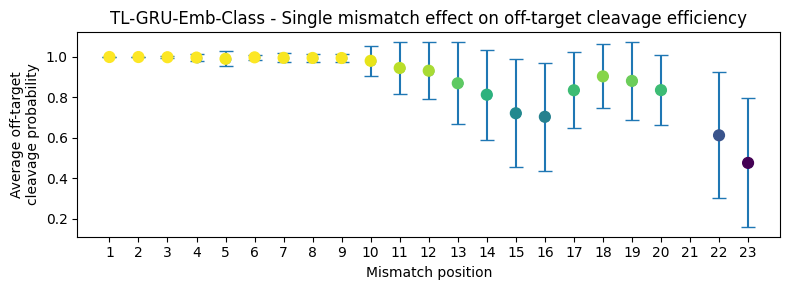

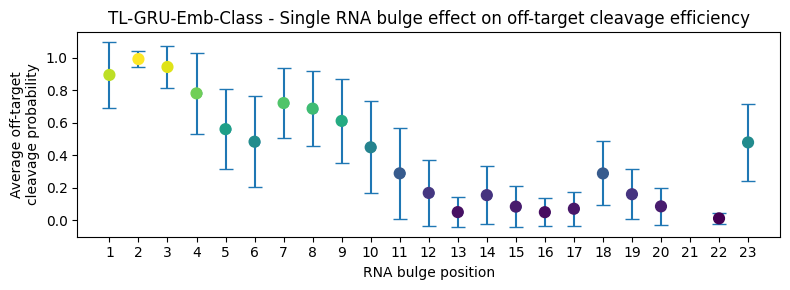

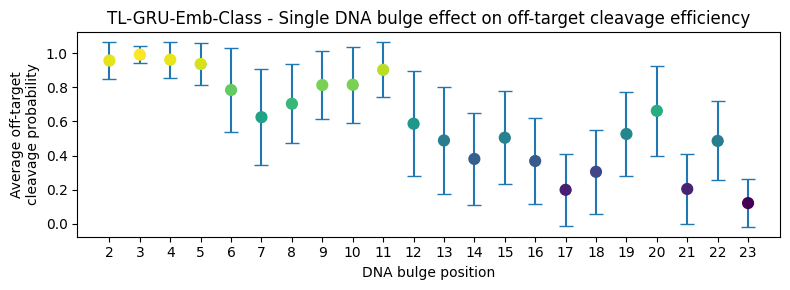

In [11]:
models = [load_model(FILES_DIR + 'bulges/1_folds/5_revision_ensemble_{}_exclude_RHAMPseq_continue_from_change_seq/read_ts_0/cleavage_models/aligned/FullGUIDEseq/classification/c_2/ln_x_plus_one_trans/model_fold_0.h5'.format(i)) for i in range(5)]
positions_plots(models, model_name="TL-GRU-Emb-Class", double=False, single=True)

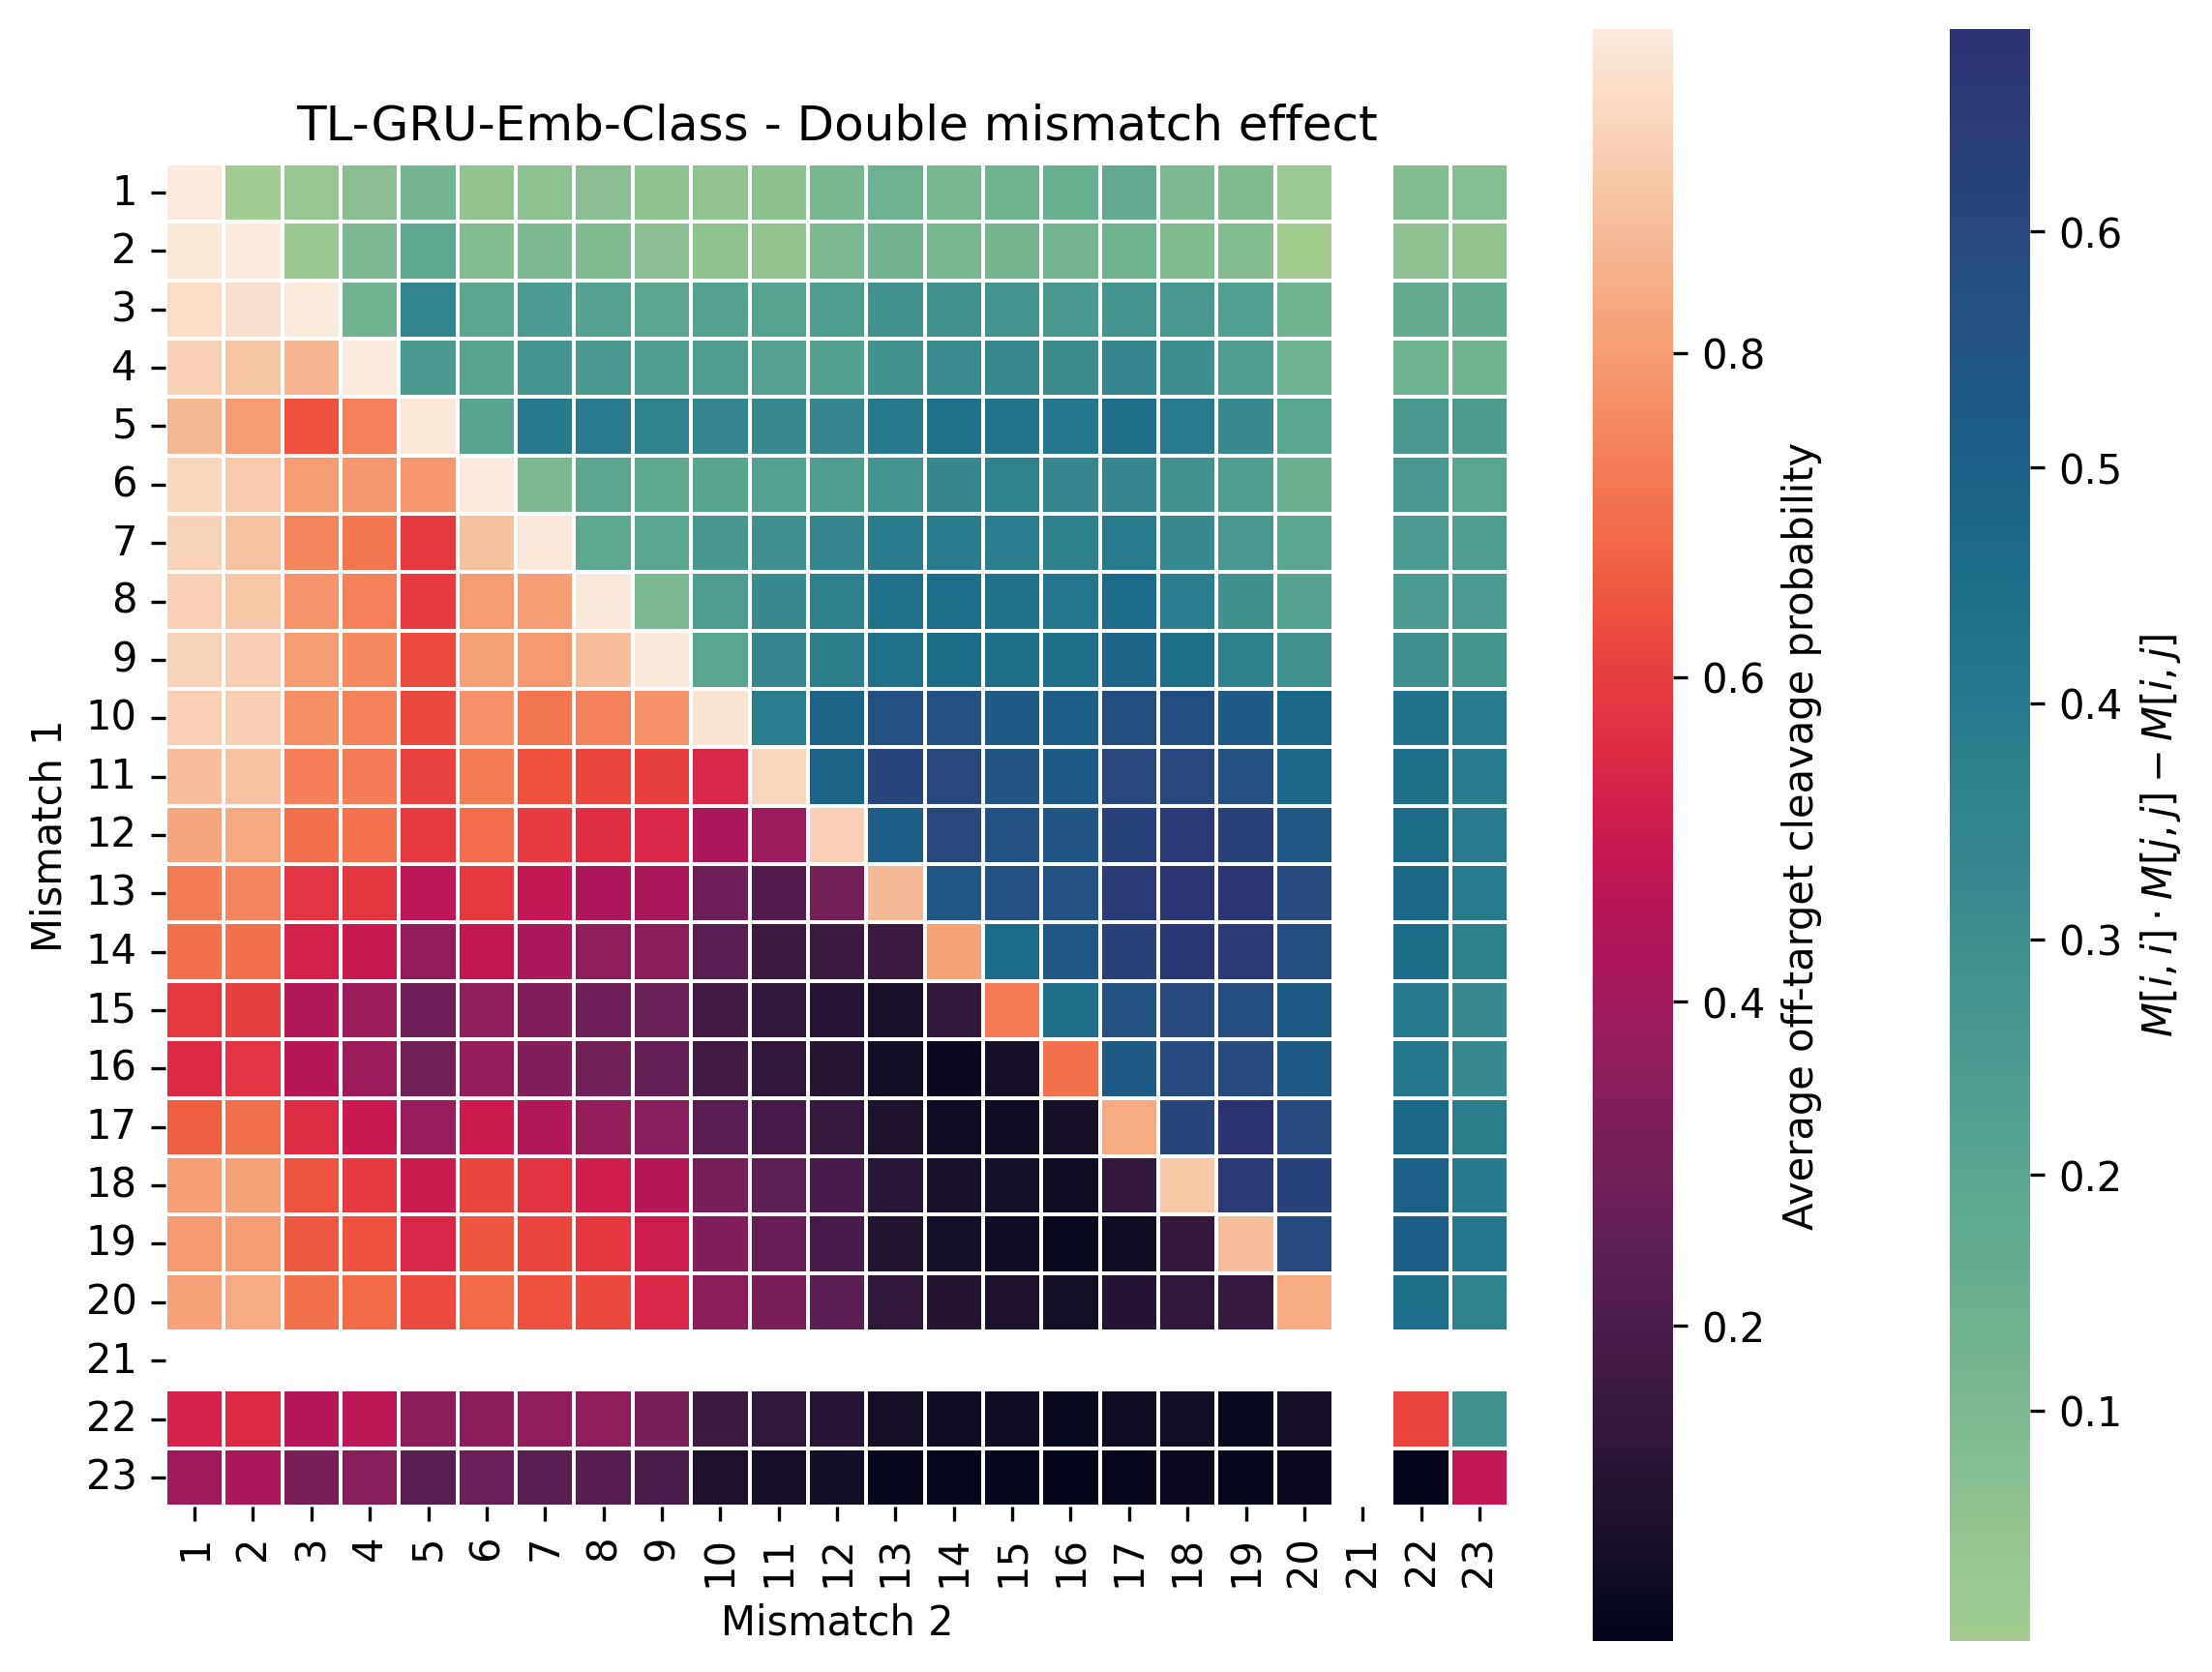

In [20]:
models = [load_model(FILES_DIR + 'bulges/1_folds/5_revision_ensemble_{}_exclude_RHAMPseq_continue_from_change_seq/read_ts_0/cleavage_models/aligned/FullGUIDEseq/classification/c_2/ln_x_plus_one_trans/model_fold_0.h5'.format(i)) for i in range(5)]
positions_plots(models, model_name="TL-GRU-Emb-Class")

2024-03-17 12:02:17.252368: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-17 12:02:17.253609: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-17 12:02:17.254507: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

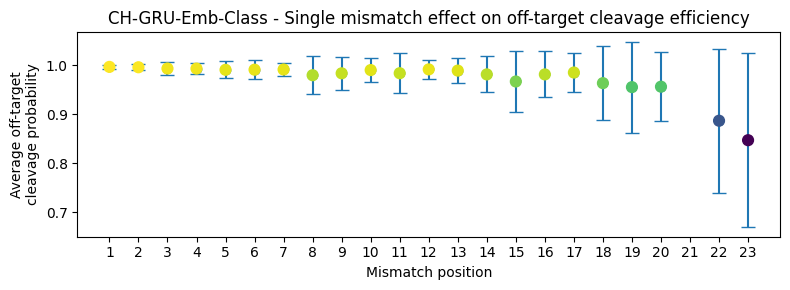

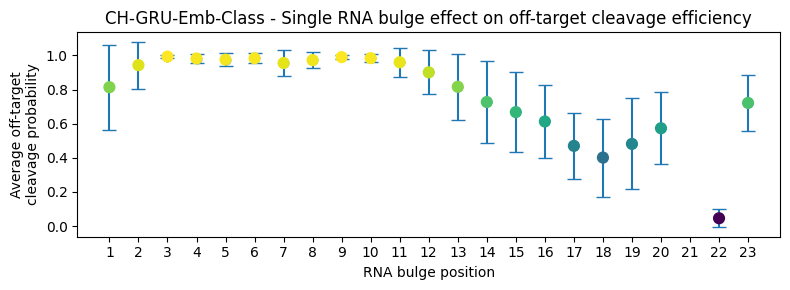

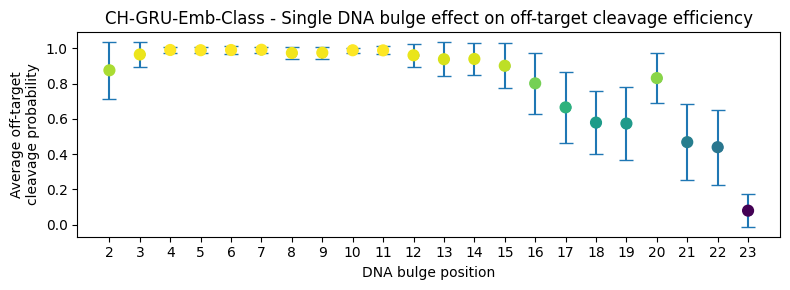

In [21]:
models = [load_model(FILES_DIR + 'bulges/1_folds/5_revision_ensemble_{}_exclude_RHAMPseq/read_ts_0/cleavage_models/aligned/CHANGEseq/classification/c_2/ln_x_plus_one_trans/model_fold_0.h5'.format(i)) for i in range(5)]
positions_plots(models, model_name="CH-GRU-Emb-Class", double=False, single=True)

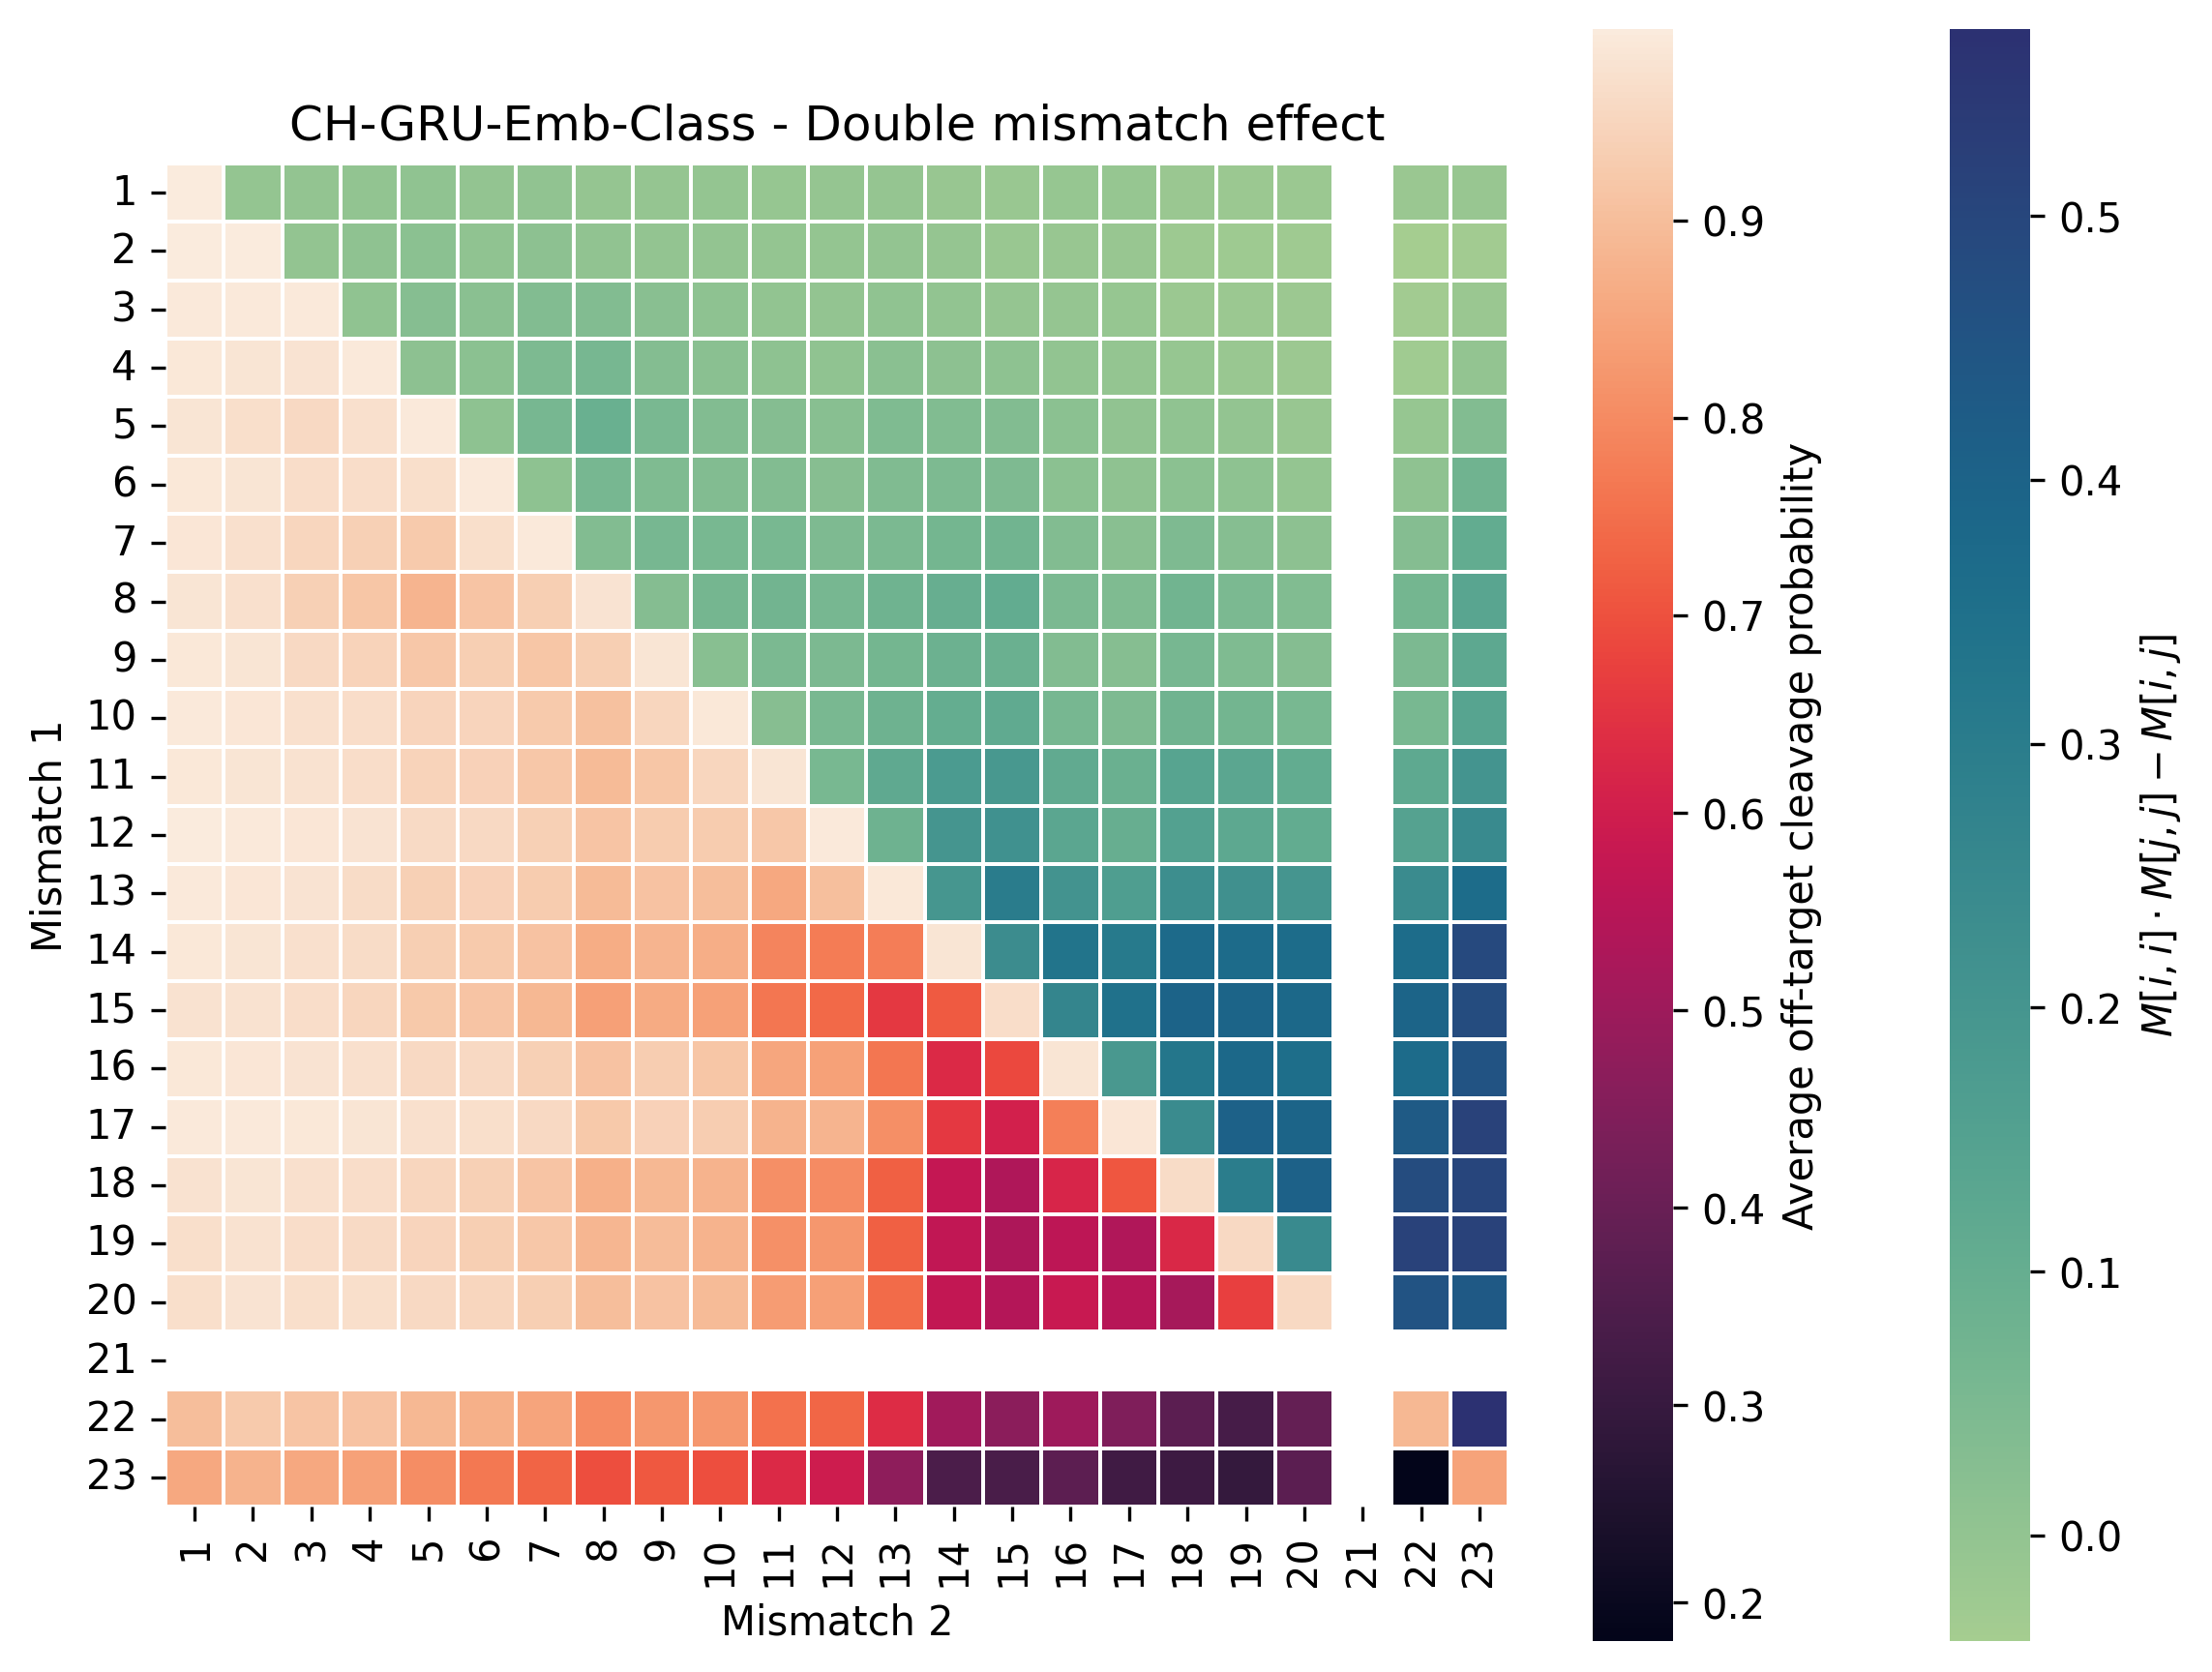

In [21]:
models = [load_model(FILES_DIR + 'bulges/1_folds/5_revision_ensemble_{}_exclude_RHAMPseq/read_ts_0/cleavage_models/aligned/CHANGEseq/classification/c_2/ln_x_plus_one_trans/model_fold_0.h5'.format(i)) for i in range(5)]
positions_plots(models, model_name="CH-GRU-Emb-Class")